<a href="https://colab.research.google.com/github/mohamed26-cyber/deep-learning/blob/main/vision/3_classification_to_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 3: From Image Classification to Image Segmentation

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Florient Chouteau | <a href="https://supaerodatascience.github.io/deep-learning/">https://supaerodatascience.github.io/deep-learning/</a>

## Learning Objectives

In the previous sessions, you learned how to train a CNN for **image classification** - predicting a single label per image (clear vs cloudy).

In this session, you will learn about **semantic segmentation** - predicting a label for **every pixel** in an image. This is a fundamental task in computer vision with applications in medical imaging, autonomous driving, satellite imagery analysis, and more.

**By the end of this session, you will:**
- Understand the difference between classification and dense prediction tasks
- Learn why classification CNNs can't directly solve segmentation
- Implement encoder-decoder architectures for dense prediction
- Understand the importance of skip connections (UNet architecture)
- Evaluate segmentation models using IoU and Dice metrics
- Apply data augmentation to segmentation tasks

**Prerequisites:**
- You should be comfortable with CNNs from Session 0
- You should have trained a classifier in Session 1

**First steps:**
- Activate GPU runtime in Colab
- Check using `!nvidia-smi` that you detect it

In [53]:
# Installation script for torchinfo package (if needed)
!pip install torchinfo

In [54]:
%matplotlib inline

In [55]:
# Put your imports here
from typing import Callable, List, Tuple

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchinfo
import tqdm
from torch import Tensor, nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

## Part 1: Understanding Segmentation - From Classification to Dense Prediction

### What is Semantic Segmentation?

**Classification** answers: "Is there a cloud in this image?" → **One label** per image

**Segmentation** answers: "Which pixels belong to clouds?" → **One label per pixel**

```
Classification:              Segmentation:
Image (64x64x3)       →     Image (64x64x3)
Model                 →     Model
Probability (1,)      →     Probability map (64x64x2)
"cloudy: 0.92"        →     "pixel [10,15]: cloud 0.95"
```

This is also called **dense prediction** because we predict at every spatial location.

![dense](https://fchouteau.github.io/isae-intro-to-cnns/static/img/computervision_tasks.png)

### Dataset

In [56]:
# Configuration variables
TRAINVAL_DATASET_URL = "https://storage.googleapis.com/fchouteau-isae-deep-learning/toy_cloud_segmentation_2025.npz"

### Utility Functions for Visualization

In [57]:
def overlay_img_msk(img, msk, color="red"):
    """Overlay an image with a colored mask"""
    c = color_to_rgb(color)
    msk = class_mask_to_color_mask(msk, class_colors=[[0, 0, 0], c])
    return overlay_img_rgb_msk(img, msk)


def overlay_img_prd(img, prd, cmap="viridis"):
    # Create overlays for ground truth and prediction without threshold
    cm = plt.get_cmap(cmap)
    pred_mask = (cm(prd)[:, :, :3] * 255.0).astype(np.uint8)

    # Overlay predicted mask on image
    pred_overlay = overlay_img_rgb_msk(img, pred_mask)

    return pred_overlay


def overlay_img_rgb_msk(img, msk, coefficients=[0.5, 0.5]):
    """
    Overlay a raw IMG and its MSK (0.5 * IMG_In_Visible + 0.5 * Msk)
    Args:
        img(np.ndarray): Img array (from imread)
        msk(np.ndarray): RGB mask

    Returns:
        np.ndarray containing the overlay (it's a copy)
    """
    tmp = np.copy(img).astype(np.float32)
    tmp2 = np.copy(msk).astype(np.float32)
    if len(tmp2.shape) == 2:
        idxs = tmp2 != 0.0
    else:
        c = tmp2.shape[2]
        idxs = ~np.all(tmp2 == [0.0 for _ in range(c)], axis=-1)

    tmp[idxs] = coefficients[0] * tmp[idxs] + coefficients[1] * tmp2[idxs]
    tmp = np.clip(tmp, 0.0, 255.0)
    tmp = tmp.astype(np.uint8)
    del tmp2

    return tmp


def color_to_rgb(color_str: str):
    """Convert color name to RGB tuple"""
    if isinstance(color_str, str):
        # https://matplotlib.org/3.1.0/gallery/color/named_colors.html
        color = np.asarray(matplotlib.colors.to_rgb(color_str))
        color = (255.0 * color).astype(np.uint8)
        color = tuple([int(c) for c in color])
        return color
    else:
        return color_str


def class_mask_to_color_mask(msk: np.ndarray, class_colors: List):
    """Convert class indices to colored mask"""
    if len(msk.shape) == 3:
        msk = msk[:, :, 0]
    color_mask = np.asarray(class_colors)[msk]
    return color_mask


def color_image_to_class_mask(msk: np.ndarray, class_colors: List):
    """Convert colored mask to class indices"""
    h, w = msk.shape[:2]
    class_mask = np.zeros((h, w)).astype(np.uint8)
    for cls_index, cls_color in enumerate(class_colors):
        cls_occ = np.all(msk == cls_color, axis=-1)
        class_mask[cls_occ] = cls_index + 1
    return class_mask

### Downloading the Dataset

We use the same cloud images as Session 1, but now with **pixel-wise masks** instead of image-level labels.

In [58]:
ds = np.lib.npyio.DataSource(destpath="/tmp/")
f = ds.open(TRAINVAL_DATASET_URL, "rb")

toy_dataset = np.load(f)
trainval_images = toy_dataset["train_images"]
trainval_labels = toy_dataset["train_labels"]
test_images = toy_dataset["test_images"]
test_labels = toy_dataset["test_labels"]

### Dataset Exploration

In [59]:
print("Training set:")
print(f"  Images shape: {trainval_images.shape}")  # (N, H, W, C)
print(f"  Labels shape: {trainval_labels.shape}")  # (N, H, W) - per-pixel labels!
print()
print("Test set:")
print(f"  Images shape: {test_images.shape}")
print(f"  Labels shape: {test_labels.shape}")
print()
print("Key difference from classification:")
print(f"  Classification labels: (N,) - one label per image")
print(f"  Segmentation labels: (N, H, W) - one label per pixel")

Training set:
  Images shape: (12800, 64, 64, 3)
  Labels shape: (12800, 64, 64)

Test set:
  Images shape: (1280, 64, 64, 3)
  Labels shape: (1280, 64, 64)

Key difference from classification:
  Classification labels: (N,) - one label per image
  Segmentation labels: (N, H, W) - one label per pixel


In [60]:
# Label distribution
LABEL_NAMES = ["Clear", "Cloud"]
unique_classes = np.unique(trainval_labels)
print(f"Classes in dataset: {unique_classes}")
print(f"Class names: {LABEL_NAMES}")
print()

# Count pixels per class (more informative than image counts for segmentation)
total_pixels = trainval_labels.size
for cls_idx, cls_name in enumerate(LABEL_NAMES):
    pixel_count = np.sum(trainval_labels == cls_idx)
    percentage = 100.0 * pixel_count / total_pixels
    print(
        f"Class '{cls_name}' (idx={cls_idx}): {pixel_count:,} pixels ({percentage:.1f}%)"
    )

Classes in dataset: [0 1]
Class names: ['Clear', 'Cloud']

Class 'Clear' (idx=0): 31,795,968 pixels (60.6%)
Class 'Cloud' (idx=1): 20,632,832 pixels (39.4%)


### Visualizing Segmentation Masks

Let's visualize images with their pixel-wise annotations overlaid in red (clouds) on the original satellite images.

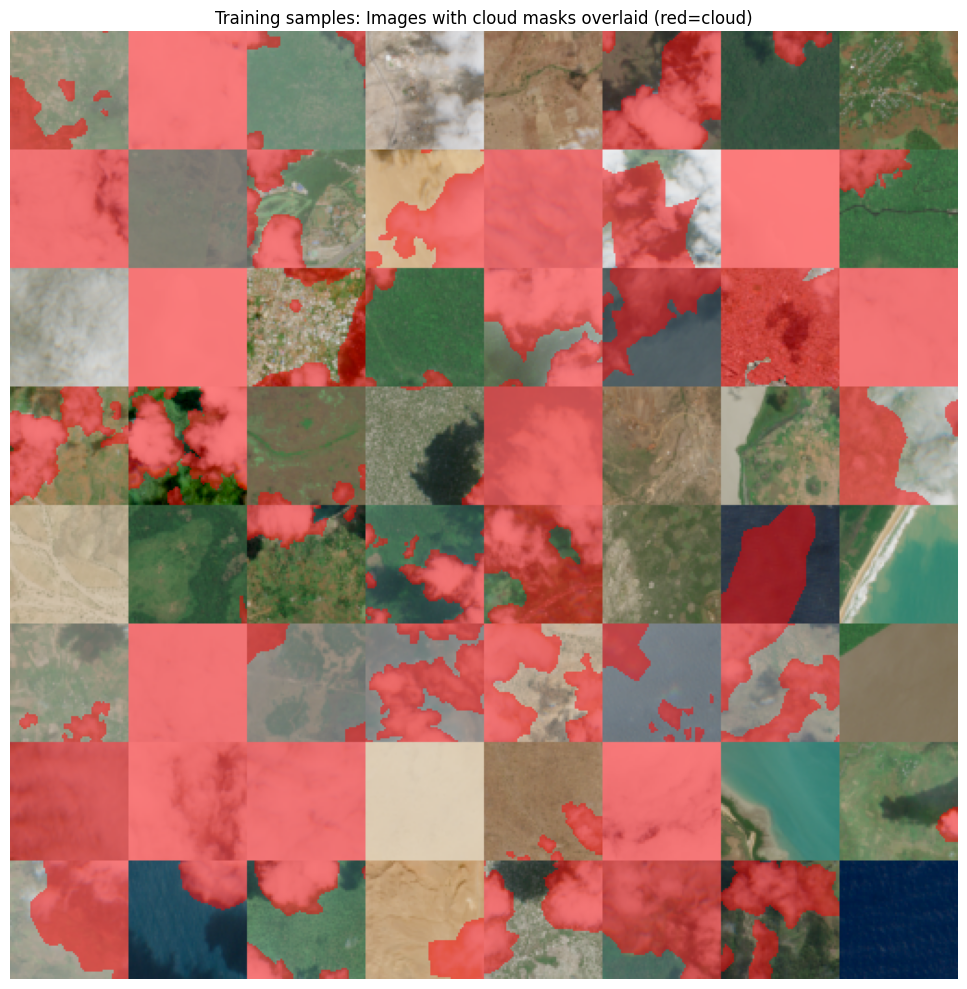

In [61]:
grid_size = 8
grid = np.zeros((grid_size * 64, grid_size * 64, 3)).astype(np.uint8)
for i in range(grid_size):
    for j in range(grid_size):
        img = trainval_images[i * grid_size + j]
        msk = trainval_labels[i * grid_size + j]
        tile = overlay_img_msk(img, msk, color="red")
        grid[i * 64 : (i + 1) * 64, j * 64 : (j + 1) * 64, :] = tile

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(grid)
ax.set_title("Training samples: Images with cloud masks overlaid (red=cloud)")
ax.axis("off")
plt.tight_layout()
plt.show()

**Observation:** These look like the same satellite images from Session 1, but now we have detailed pixel-level annotations showing exactly where clouds are located, not just whether the image contains clouds.

### Train/Validation Split

Just like in Session 1, we split our training data into train and validation sets (80/20).

In [62]:
idxs = np.random.permutation(np.arange(trainval_images.shape[0]))
train_idxs, val_idxs = idxs[: int(0.8 * len(idxs))], idxs[int(0.8 * len(idxs)) :]

train_images = trainval_images[train_idxs]
train_labels = trainval_labels[train_idxs]
val_images = trainval_images[val_idxs]
val_labels = trainval_labels[val_idxs]

print(f"Train set: {train_images.shape[0]} samples")
print(f"Val set: {val_images.shape[0]} samples")
print(f"Test set: {test_images.shape[0]} samples")

Train set: 10240 samples
Val set: 2560 samples
Test set: 1280 samples


### Computing Dataset Statistics

We'll reuse the normalization from Session 1 (computed on the classification dataset).
Since we're using the same underlying images, the statistics are similar.

In [63]:
# Compute mean and std for normalization (in [0, 1] range)
mean = np.mean(train_images, axis=(0, 1, 2)) / 255.0
std = np.std(train_images, axis=(0, 1, 2)) / 255.0

print(f"Dataset normalization statistics:")
print(f"  Mean: {mean}")
print(f"  Std:  {std}")

Dataset normalization statistics:
  Mean: [0.54324612 0.56888144 0.51710345]
  Std:  [0.23702453 0.20137279 0.2286703 ]


## Part 2: Can We Reuse Classification Models?

### The Challenge: From 1 Output to 64×64 Outputs

In Session 1, our classification CNN had this structure:

```
Input: (B, 3, 64, 64)
  ↓ Conv blocks (downsample with pooling)
Features: (B, C, 8, 8) - spatial resolution reduced
  ↓ Flatten + MLP
Output: (B, 1) - single probability
```

For segmentation, we need:

```
Input: (B, 3, 64, 64)
  ↓ ??? Architecture ???
Output: (B, 2, 64, 64) - probability for each pixel
```

**Key problems:**
1. **Flattening destroys spatial information** - we can't recover pixel positions after flatten()
2. **Pooling reduces resolution** - we need to upsample back to original size
3. **Need to preserve spatial structure** - which pixels are neighbors matters!

**Solution:** **Encoder-Decoder** architectures
- **Encoder**: Downsample to extract features (like classification CNN)
- **Decoder**: Upsample features back to original resolution
- Output: Per-pixel predictions via 1×1 convolution

![encoderdecoder](https://towardsdatascience.com/wp-content/uploads/2022/11/1XeUglwXyh7967mlMOF20Zw.png)

### Understanding Upsampling Operations

#### The Upsampling Challenge

Before we build our segmentation models, we need to understand **upsampling** - the operation that increases spatial resolution.

**Recap: Downsampling (what we know)**
- **MaxPool2d**: Reduces spatial size (64×64 → 32×32)
- **Strided Conv**: Conv with stride > 1 also downsamples
- Non-learnable: no parameters to train

**New: Upsampling (what we need)**
- Increase spatial size (8×8 → 16×16 → 32×32 → 64×64)
- Two approaches:
  1. **Non-learnable**: Fixed interpolation (nearest, bilinear)
  2. **Learnable**: Transposed convolution (has trainable weights)

### Approach 1: Non-Learnable Upsampling

**Nearest Neighbor Upsampling:**
- Repeat each pixel value
- Fast but creates blocky artifacts

**Bilinear Upsampling:**
- Interpolate between pixels
- Smoother but still not learnable

```
Original (2×2):     Nearest Neighbor (4×4):    Bilinear (4×4):
[1  2]              [1  1  2  2]               [1.0  1.3  1.7  2.0]
[3  4]              [1  1  2  2]               [1.7  2.0  2.3  2.7]
                    [3  3  4  4]               [2.3  2.7  3.0  3.3]
                    [3  3  4  4]               [3.0  3.3  3.7  4.0]
```

![](https://mriquestions.com/uploads/3/4/5/7/34572113/uppooling-methods_orig.png)

### Approach 2: Transposed Convolution (Learnable Upsampling)

**Key Idea:** Like regular convolution, but in reverse - **increases** spatial size while learning optimal upsampling.

**Regular Convolution (downsampling):**
- Applies kernel to input → smaller output
- Example: 4×4 input + 3×3 kernel (stride=2) → 2×2 output

**Transposed Convolution (upsampling):**
- Applies kernel in a "reverse" manner → larger output
- Example: 2×2 input + 3×3 kernel (stride=2) → 4×4 output
- **Learnable**: The kernel weights are trained via backpropagation!

**Why "transposed"?**
- The operation is mathematically related to the transpose of the convolution matrix

![tconv](https://towardsdatascience.com/wp-content/uploads/2022/06/1kv5m8-VXHZ5RzHu70Jt_BQ.png)

### Visual Example: Strided Convolution vs Transposed Convolution

Let's see how convolution reduces size and transposed convolution increases it.

In [64]:
# Example 1: Strided Convolution (Downsampling)
print("=" * 60)
print("STRIDED CONVOLUTION (Downsampling)")
print("=" * 60)

# Create a simple 4×4 input
input_tensor = torch.arange(1, 17, dtype=torch.float32).reshape(1, 1, 4, 4)
print("\nInput (4×4):")
print(input_tensor.squeeze().numpy())

# Define a 3×3 convolution with stride=2 (downsamples)
conv_down = nn.Conv2d(
    in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=0, bias=False
)
# Initialize with known weights for clarity
conv_down.weight.data = torch.ones(1, 1, 3, 3) * 0.1

output_down = conv_down(input_tensor)
print(f"\nAfter Conv2d(kernel=3, stride=2, padding=0):")
print(f"Output shape: {output_down.shape} (spatial size reduced: 4×4 → 2×2)")
print("Output (2×2):")
print(output_down.squeeze().detach().numpy())

STRIDED CONVOLUTION (Downsampling)

Input (4×4):
[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]]

After Conv2d(kernel=3, stride=2, padding=0):
Output shape: torch.Size([1, 1, 1, 1]) (spatial size reduced: 4×4 → 2×2)
Output (2×2):
5.4


In [65]:
# Example 2: Transposed Convolution (Upsampling)
print("\n" + "=" * 60)
print("TRANSPOSED CONVOLUTION (Upsampling)")
print("=" * 60)

# Start with the 2×2 output from above
input_small = output_down

# Define a transposed convolution with stride=2 (upsamples)
conv_up = nn.ConvTranspose2d(
    in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=0, bias=False
)
# Initialize with known weights
conv_up.weight.data = torch.ones(1, 1, 3, 3) * 0.1

output_up = conv_up(input_small)
print(f"\nAfter ConvTranspose2d(kernel=3, stride=2, padding=0):")
print(f"Output shape: {output_up.shape} (spatial size increased: 2×2 → 5×5)")
print("Output (5×5):")
print(output_up.squeeze().detach().numpy())

print(
    "\n✓ Notice: TransposedConv with stride=2 approximately doubles spatial dimensions"
)


TRANSPOSED CONVOLUTION (Upsampling)

After ConvTranspose2d(kernel=3, stride=2, padding=0):
Output shape: torch.Size([1, 1, 3, 3]) (spatial size increased: 2×2 → 5×5)
Output (5×5):
[[0.54 0.54 0.54]
 [0.54 0.54 0.54]
 [0.54 0.54 0.54]]

✓ Notice: TransposedConv with stride=2 approximately doubles spatial dimensions


### Controlling Output Size with Transposed Convolution

**Common pattern for exact size doubling:**
- `kernel_size=2, stride=2, padding=0` → Exactly doubles spatial size
- Example: 8×8 → 16×16, 16×16 → 32×32

**Formula for output size:**
```
output_size = (input_size - 1) * stride - 2 * padding + kernel_size
```

Let's verify this works for our decoder:

In [66]:
print("=" * 60)
print("EXACT SIZE DOUBLING FOR DECODER")
print("=" * 60)

# Simulate decoder upsampling path
sizes = [8, 16, 32, 64]
for i in range(len(sizes) - 1):
    input_size = sizes[i]
    target_size = sizes[i + 1]

    # Create dummy input
    dummy = torch.randn(1, 64, input_size, input_size)

    # Transposed conv with kernel=2, stride=2
    upconv = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0)
    output = upconv(dummy)

    print(
        f"\nLevel {i+1}: {input_size}×{input_size} → {output.shape[2]}×{output.shape[3]}"
    )
    print(f"  Using: ConvTranspose2d(kernel=2, stride=2)")
    print(
        f"  Expected: {target_size}×{target_size} | Actual: {output.shape[2]}×{output.shape[3]}"
    )
    assert output.shape[2] == target_size, "Size mismatch!"

print("\n✓ All upsampling steps produce correct sizes!")

EXACT SIZE DOUBLING FOR DECODER

Level 1: 8×8 → 16×16
  Using: ConvTranspose2d(kernel=2, stride=2)
  Expected: 16×16 | Actual: 16×16

Level 2: 16×16 → 32×32
  Using: ConvTranspose2d(kernel=2, stride=2)
  Expected: 32×32 | Actual: 32×32

Level 3: 32×32 → 64×64
  Using: ConvTranspose2d(kernel=2, stride=2)
  Expected: 64×64 | Actual: 64×64

✓ All upsampling steps produce correct sizes!


### How Transposed Convolution Works (Detailed)

**Visual intuition for stride=2:**

1. **Insert zeros** between input pixels (creates spacing)
2. **Apply standard convolution** on the expanded input
3. Result: Larger output!

```
Input (2×2):        After zero insertion:    After convolution:
[a  b]              [a  0  b  0]             [... larger output ...]
[c  d]              [0  0  0  0]
                    [c  0  d  0]
                    [0  0  0  0]
```

**Key differences from regular Conv:**

| Property | Conv2d | ConvTranspose2d |
|----------|--------|-----------------|
| **Purpose** | Extract features, downsample | Upsample, reconstruct spatial info |
| **Spatial effect** | Reduces size (stride > 1) | Increases size (stride > 1) |
| **Parameters** | Learnable kernel | Learnable kernel |
| **Use case** | Encoder | Decoder |

### Comparing Upsampling Methods

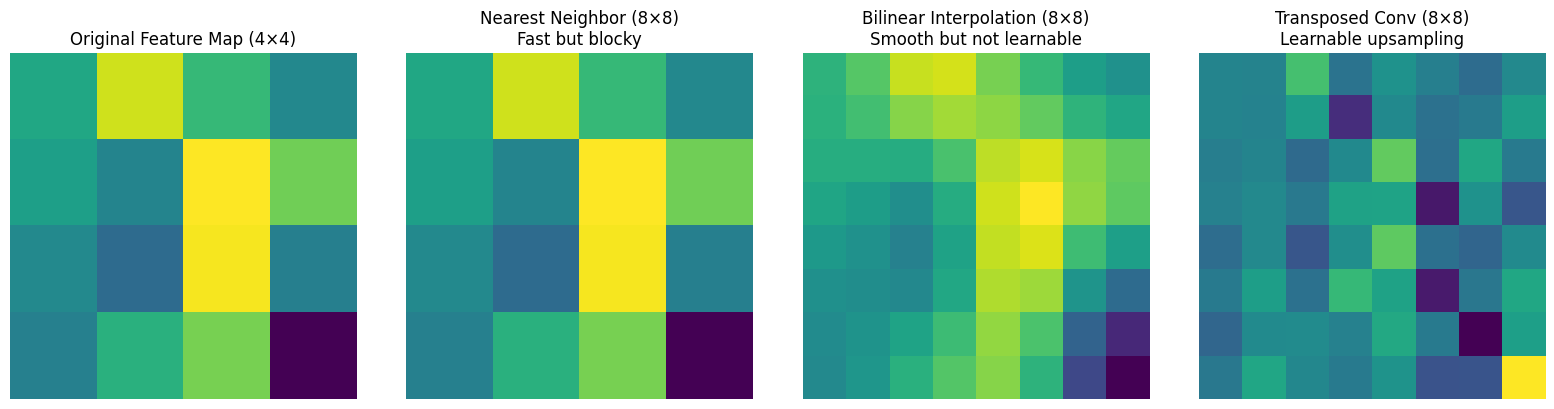

Visual comparison:
  Nearest:    Blocky artifacts, no learning
  Bilinear:   Smooth, but fixed interpolation
  Transposed: Learnable kernel adapts to data!


In [67]:
# Create a small feature map to upsample
small_feature = torch.randn(1, 1, 4, 4)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Original
axes[0].imshow(small_feature.squeeze().numpy(), cmap="viridis")
axes[0].set_title("Original Feature Map (4×4)")
axes[0].axis("off")

# Method 1: Nearest Neighbor
upsampled_nearest = F.interpolate(small_feature, scale_factor=2, mode="nearest")
axes[1].imshow(upsampled_nearest.squeeze().numpy(), cmap="viridis")
axes[1].set_title("Nearest Neighbor (8×8)\nFast but blocky")
axes[1].axis("off")

# Method 2: Bilinear
upsampled_bilinear = F.interpolate(
    small_feature, scale_factor=2, mode="bilinear", align_corners=False
)
axes[2].imshow(upsampled_bilinear.squeeze().numpy(), cmap="viridis")
axes[2].set_title("Bilinear Interpolation (8×8)\nSmooth but not learnable")
axes[2].axis("off")

# Method 3: Transposed Convolution
transposed_conv = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2, padding=0)
upsampled_transposed = transposed_conv(small_feature)
axes[3].imshow(upsampled_transposed.squeeze().detach().numpy(), cmap="viridis")
axes[3].set_title("Transposed Conv (8×8)\nLearnable upsampling")
axes[3].axis("off")

plt.tight_layout()
plt.show()

print("Visual comparison:")
print(f"  Nearest:    {'Blocky artifacts, no learning'}")
print(f"  Bilinear:   {'Smooth, but fixed interpolation'}")
print(f"  Transposed: {'Learnable kernel adapts to data!'}")

### Why Use Transposed Convolution for Segmentation?

**Advantages:**
1. **Learnable**: Kernel weights adapt to your specific task
2. **End-to-end training**: Gradients flow through upsampling layers
3. **Feature-aware**: Can learn to upsample different features differently
4. **Better reconstruction**: Especially for complex patterns

**Disadvantages:**
1. **Checkerboard artifacts**: Can create unwanted patterns (fixable with careful kernel size)
2. **More parameters**: Slightly more memory than interpolation
3. **Slower**: More computation than simple interpolation

**Bottom line:** For segmentation, the learnable upsampling is worth it!

### Practical Tips for Transposed Convolution

**1. Checkerboard Artifacts:**
- Problem: `kernel_size` not divisible by `stride` → overlapping outputs
- Solution: Use `kernel_size` that is multiple of `stride`
- Example: `kernel_size=2, stride=2` or `kernel_size=4, stride=2`

**2. Size Matching:**
- For exact doubling: `kernel_size=2, stride=2, padding=0`
- Alternative: `kernel_size=4, stride=2, padding=1` (reduces artifacts)

**3. Combination with Conv:**
- Common pattern: `ConvTranspose2d` → `Conv2d` → `ReLU`
- The Conv2d after upsampling refines the output and reduces artifacts

### Summary: Upsampling for Segmentation

| Method | Learnable? | Quality | Speed | Use Case |
|--------|-----------|---------|-------|----------|
| **Nearest** | ❌ | Low (blocky) | Fast | Quick prototyping |
| **Bilinear** | ❌ | Medium (smooth) | Fast | Non-critical upsampling |
| **Transposed Conv** | ✅ | High (adaptive) | Slower | **Segmentation decoders** |

**For the rest of this notebook:**
- We'll use `nn.ConvTranspose2d` in our decoder
- This allows the model to **learn optimal upsampling** for cloud segmentation
- The decoder weights will be trained jointly with the encoder

## Part 3: Preparing for Training

### Dataset Class for Segmentation

Similar to Session 1, but now labels are masks (H, W) instead of scalars.

In [68]:
class SegmentationDataset(Dataset):
    """
    PyTorch Dataset for segmentation.
    Images: (N, H, W, 3) uint8 arrays
    Labels: (N, H, W) uint8 arrays with class indices
    """

    def __init__(
        self,
        images: np.ndarray,
        labels: np.ndarray,
        image_transforms: Callable = None,
        label_transforms: Callable = None,
    ):
        self.images = images
        self.labels = labels
        self.image_transforms = image_transforms
        self.label_transforms = label_transforms

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index: int):
        x = self.images[index]  # (H, W, 3)
        y = self.labels[index]  # (H, W)

        if self.image_transforms is not None:
            x = self.image_transforms(x)
        else:
            x = torch.tensor(x).permute(2, 0, 1).float() / 255.0

        if self.label_transforms is not None:
            y = self.label_transforms(y)
        else:
            y = torch.tensor(y).long()  # CrossEntropyLoss expects Long

        return x, y

### Transforms for Images and Masks

**Important:** For segmentation, we normalize images but keep masks as integer class indices.

In [69]:
# Image transforms: convert to tensor and normalize
image_transforms = transforms.Compose(
    [
        transforms.ToTensor(),  # Converts (H,W,3) -> (3,H,W) and scales to [0,1]
        transforms.Normalize(mean, std),
    ]
)


# Label transforms: just convert to tensor (keep as integers)
def label_transform(label):
    return torch.tensor(label).long()

In [70]:
# Create datasets
train_dataset = SegmentationDataset(
    train_images,
    train_labels,
    image_transforms=image_transforms,
    label_transforms=label_transform,
)

val_dataset = SegmentationDataset(
    val_images,
    val_labels,
    image_transforms=image_transforms,
    label_transforms=label_transform,
)

test_dataset = SegmentationDataset(
    test_images,
    test_labels,
    image_transforms=image_transforms,
    label_transforms=label_transform,
)

In [71]:
# Check a sample
sample_img, sample_mask = train_dataset[0]
print(f"Image tensor shape: {sample_img.shape}")  # (3, 64, 64)
print(f"Mask tensor shape: {sample_mask.shape}")  # (64, 64)
print(f"Mask dtype: {sample_mask.dtype}")  # torch.int64
print(f"Mask unique values: {torch.unique(sample_mask)}")  # Should be [0, 1]

Image tensor shape: torch.Size([3, 64, 64])
Mask tensor shape: torch.Size([64, 64])
Mask dtype: torch.int64
Mask unique values: tensor([0, 1])


### Verifying Transforms with Inverse Transform

**Following Andrej Karpathy's advice:** Always verify your data pipeline by inverse-transforming a sample.
This catches bugs like wrong normalization, incorrect channel order, etc.

In [72]:
def inverse_transform(img_tensor, mean, std):
    """
    Inverse normalization to visualize transformed images
    Args:
        img_tensor: (3, H, W) normalized tensor
    Returns:
        (H, W, 3) uint8 numpy array
    """
    mean_t = torch.tensor(mean).view(3, 1, 1)
    std_t = torch.tensor(std).view(3, 1, 1)
    img = img_tensor * std_t + mean_t  # Denormalize
    img = img.clamp(0, 1)  # Clip to valid range
    img = (img * 255).byte()  # Scale to [0, 255]
    img = img.permute(1, 2, 0).numpy()  # (3,H,W) -> (H,W,3)
    return img

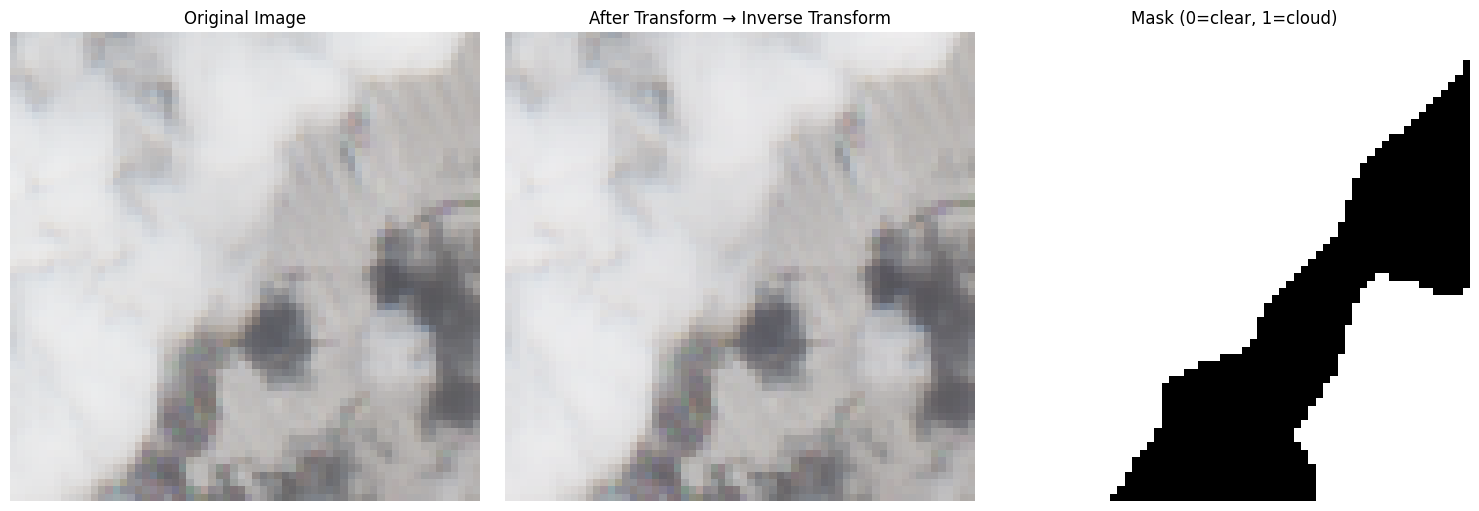

✓ Inverse transform looks correct - proceeding with training!


In [73]:
# Verify inverse transform
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original
axes[0].imshow(train_images[1])
axes[0].set_title("Original Image")
axes[0].axis("off")

# After transforms + inverse
sample_img, sample_mask = train_dataset[1]
reconstructed = inverse_transform(sample_img, mean, std)
axes[1].imshow(reconstructed)
axes[1].set_title("After Transform → Inverse Transform")
axes[1].axis("off")

# Mask visualization
axes[2].imshow(sample_mask.numpy(), cmap="gray")
axes[2].set_title("Mask (0=clear, 1=cloud)")
axes[2].axis("off")

plt.tight_layout()
plt.show()

print("✓ Inverse transform looks correct - proceeding with training!")

### DataLoaders

In [74]:
BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 640
Val batches: 160
Test batches: 80


### Device Setup

In [75]:
# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✓ Using GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✓ Using Apple Silicon GPU (MPS)")
else:
    device = torch.device("cpu")
    print("⚠ Using CPU - training will be slow!")

✓ Using GPU: Tesla T4


## Part 4: Basic FCN (Fully Convolutional Network)

### FCN Architecture Overview

A **Fully Convolutional Network** (FCN) has two parts:

**Encoder (Downsampling path):**
```
(3, 64, 64)
  ↓ Conv + Pool
(32, 32, 32)
  ↓ Conv + Pool
(64, 16, 16)
  ↓ Conv + Pool
(128, 8, 8)  ← Bottleneck
```

**Decoder (Upsampling path):**
```
(128, 8, 8)
  ↓ TransposedConv (upsample)
(64, 16, 16)
  ↓ TransposedConv (upsample)
(32, 32, 32)
  ↓ TransposedConv (upsample)
(16, 64, 64)
  ↓ 1×1 Conv (classification)
(2, 64, 64)  ← Output (2 classes per pixel)
```

**Key operations:**
- `nn.Conv2d`: Extract features
- `nn.MaxPool2d`: Downsample (reduce spatial resolution)
- `nn.ConvTranspose2d`: Upsample (increase spatial resolution)
- Final 1×1 conv: Per-pixel classification

![encoderdecoder](https://towardsdatascience.com/wp-content/uploads/2022/11/1XeUglwXyh7967mlMOF20Zw.png)

### Building Blocks

In [76]:
class ConvBlock(nn.Module):
    """
    Basic convolutional block: Conv → ReLU → Conv → ReLU
    Used in encoder path
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        return x

### FCN Encoder (Feature Extraction)

In [77]:
class FCNEncoder(nn.Module):
    """
    Encoder: Downsample input to extract hierarchical features
    64×64 → 32×32 → 16×16 → 8×8
    """

    def __init__(self):
        super().__init__()
        # Level 1: 64×64
        self.conv1 = ConvBlock(3, 32)
        self.pool1 = nn.MaxPool2d(2)  # → 32×32

        # Level 2: 32×32
        self.conv2 = ConvBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)  # → 16×16

        # Level 3: 16×16
        self.conv3 = ConvBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2)  # → 8×8

    def forward(self, x):
        # Encoder path
        x1 = self.conv1(x)  # (32, 64, 64)
        x = self.pool1(x1)  # (32, 32, 32)

        x2 = self.conv2(x)  # (64, 32, 32)
        x = self.pool2(x2)  # (64, 16, 16)

        x3 = self.conv3(x)  # (128, 16, 16)
        x = self.pool3(x3)  # (128, 8, 8)

        return x

### FCN Decoder (Upsampling)

**Exercise:** Complete the decoder that upsamples features back to original resolution.

**Hints:**
- Use `nn.ConvTranspose2d` with `stride=2` to double spatial dimensions
- Use `ConvBlock` after each upsampling to refine features
- Final layer should output 1 channel (binary segmentation: cloud probability)

In [78]:
class FCNDecoder(nn.Module):
    """
    Decoder: Upsample features back to input resolution
    8×8 → 16×16 → 32×32 → 64×64
    """

    def __init__(self):
        super().__init__()
        # Level 1: 8×8 → 16×16
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1 = ConvBlock(64, 64)

        # Level 2: 16×16 → 32×32
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv2 = ConvBlock(32, 32)

        # Level 3: 32×32 → 64×64
        self.upconv3 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv3 = ConvBlock(16, 16)

        # Final layer: 1×1 conv + Sigmoid for binary segmentation
        self.final_conv = nn.Conv2d(16, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Decoder path
        x = self.upconv1(x)  # (64, 16, 16)
        x = self.conv1(x)  # Refine features

        x = self.upconv2(x)  # (32, 32, 32)
        x = self.conv2(x)  # Refine features

        x = self.upconv3(x)  # (16, 64, 64)
        x = self.conv3(x)  # Refine features

        x = self.final_conv(x)  # (1, 64, 64) - logits
        x = self.sigmoid(x)  # (1, 64, 64) - probabilities in [0, 1]

        return x

### Complete FCN Model

In [79]:
class FCN(nn.Module):
    """
    Fully Convolutional Network for binary segmentation
    Input: (B, 3, H, W)
    Output: (B, 1, H, W) - cloud probability per pixel
    """

    def __init__(self):
        super().__init__()
        self.encoder = FCNEncoder()
        self.decoder = FCNDecoder()

    def forward(self, x):
        # Encode
        features = self.encoder(x)
        # Decode
        output = self.decoder(features)
        return output

In [80]:
# Instantiate model
fcn_model = FCN().to(device)

In [81]:
# Verify architecture and output shape
dummy_input = torch.randn(2, 3, 64, 64).to(device)
dummy_output = fcn_model(dummy_input)
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {dummy_output.shape}")
print(f"Output range: [{dummy_output.min():.3f}, {dummy_output.max():.3f}]")
print(f"✓ Output has correct shape: (batch_size, 1, H, W)")
print(f"✓ Output is probability in [0, 1] range (Sigmoid applied)")

Input shape: torch.Size([2, 3, 64, 64])
Output shape: torch.Size([2, 1, 64, 64])
Output range: [0.523, 0.526]
✓ Output has correct shape: (batch_size, 1, H, W)
✓ Output is probability in [0, 1] range (Sigmoid applied)


In [82]:
# Model summary
print("\nFCN Architecture:")
torchinfo.summary(fcn_model, input_size=(1, 3, 64, 64), device=device)


FCN Architecture:


Layer (type:depth-idx)                   Output Shape              Param #
FCN                                      [1, 1, 64, 64]            --
├─FCNEncoder: 1-1                        [1, 128, 8, 8]            --
│    └─ConvBlock: 2-1                    [1, 32, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 32, 64, 64]           896
│    │    └─ReLU: 3-2                    [1, 32, 64, 64]           --
│    │    └─Conv2d: 3-3                  [1, 32, 64, 64]           9,248
│    │    └─ReLU: 3-4                    [1, 32, 64, 64]           --
│    └─MaxPool2d: 2-2                    [1, 32, 32, 32]           --
│    └─ConvBlock: 2-3                    [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-5                  [1, 64, 32, 32]           18,496
│    │    └─ReLU: 3-6                    [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-7                  [1, 64, 32, 32]           36,928
│    │    └─ReLU: 3-8                    [1, 64, 32, 32]           --
│  

### Training Configuration

In [83]:
# Hyperparameters
EPOCHS = 5
LEARNING_RATE = 5e-4

# Loss function: Binary Cross Entropy for binary segmentation
# Input: (B, 1, H, W) probabilities after sigmoid, Target: (B, H, W) binary masks
# We use BCELoss since Sigmoid is already applied in the model
criterion = nn.BCELoss()

# Optimizer
optimizer = optim.Adam(fcn_model.parameters(), lr=LEARNING_RATE)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")

Loss function: BCELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)


### Training Loop

In [84]:
def train_epoch_segmentation(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0

    for batch_idx, (images, masks) in enumerate(dataloader):
        images = images.to(device)
        masks = masks.to(device).float()  # Convert to float for BCE

        # Forward pass
        outputs = model(images)  # (B, 1, H, W) probabilities
        # BCE expects same shape for predictions and targets
        masks_expanded = masks.unsqueeze(1)  # (B, H, W) → (B, 1, H, W)
        loss = criterion(outputs, masks_expanded)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)


def val_epoch_segmentation(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device).float()

            outputs = model(images)  # (B, 1, H, W)
            masks_expanded = masks.unsqueeze(1)  # (B, H, W) → (B, 1, H, W)
            loss = criterion(outputs, masks_expanded)

            running_loss += loss.item()

    return running_loss / len(dataloader)

In [85]:
# Training loop
fcn_train_losses = []
fcn_val_losses = []

print("Training FCN...")
for epoch in tqdm.trange(EPOCHS):
    train_loss = train_epoch_segmentation(
        fcn_model, train_loader, criterion, optimizer, device
    )
    val_loss = val_epoch_segmentation(fcn_model, val_loader, criterion, device)

    fcn_train_losses.append(train_loss)
    fcn_val_losses.append(val_loss)

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

print("✓ FCN training complete!")

Training FCN...


100%|██████████| 5/5 [00:45<00:00,  9.08s/it]

Epoch [5/5] - Train Loss: 0.2931, Val Loss: 0.2763
✓ FCN training complete!


### Training Curves

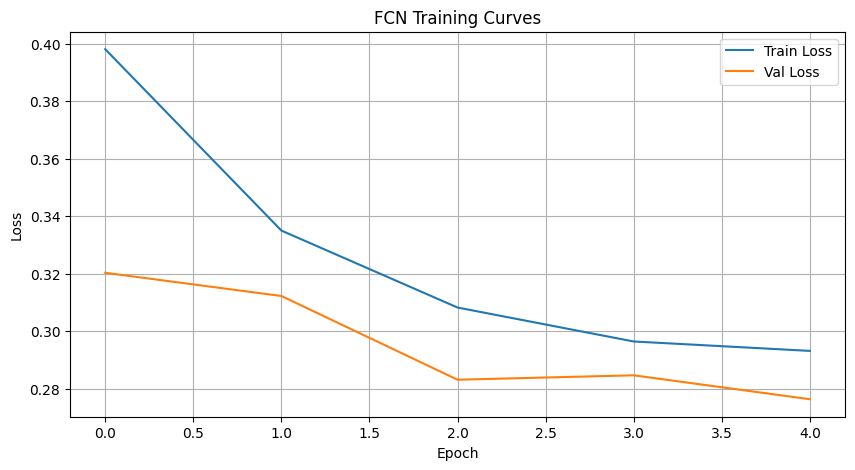

In [86]:
plt.figure(figsize=(10, 5))
plt.plot(fcn_train_losses, label="Train Loss")
plt.plot(fcn_val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("FCN Training Curves")
plt.legend()
plt.grid(True)
plt.show()

### Visualizing FCN Predictions

In [87]:
def visualize_segmentation_predictions(model, dataset, device, num_samples=8):
    """Visualize model predictions on validation set"""
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))

    with torch.no_grad():
        for i in range(num_samples):
            img_tensor, mask_gt = dataset[i]
            img_tensor_batch = img_tensor.unsqueeze(0).to(device)

            # Predict
            output = model(img_tensor_batch)  # (1, 1, H, W) probabilities
            pred_mask = output.squeeze(0).squeeze(0).cpu()  # (H, W) float in [0, 1]

            # Inverse transform for visualization
            img_np = inverse_transform(img_tensor, mean, std)

            # Overlay ground truth mask on image
            gt_overlay = overlay_img_msk(img_np, mask_gt.numpy(), color="red")

            # Overlay predicted mask on image
            pred_overlay = overlay_img_prd(img_np, pred_mask, cmap="jet")

            # Display
            axes[i, 0].imshow(img_np)
            axes[i, 0].set_title("Image")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(gt_overlay)
            axes[i, 1].set_title("Ground Truth (green=cloud)")
            axes[i, 1].axis("off")

            axes[i, 2].imshow(pred_overlay)
            axes[i, 2].set_title("FCN Prediction (red=cloud)")
            axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

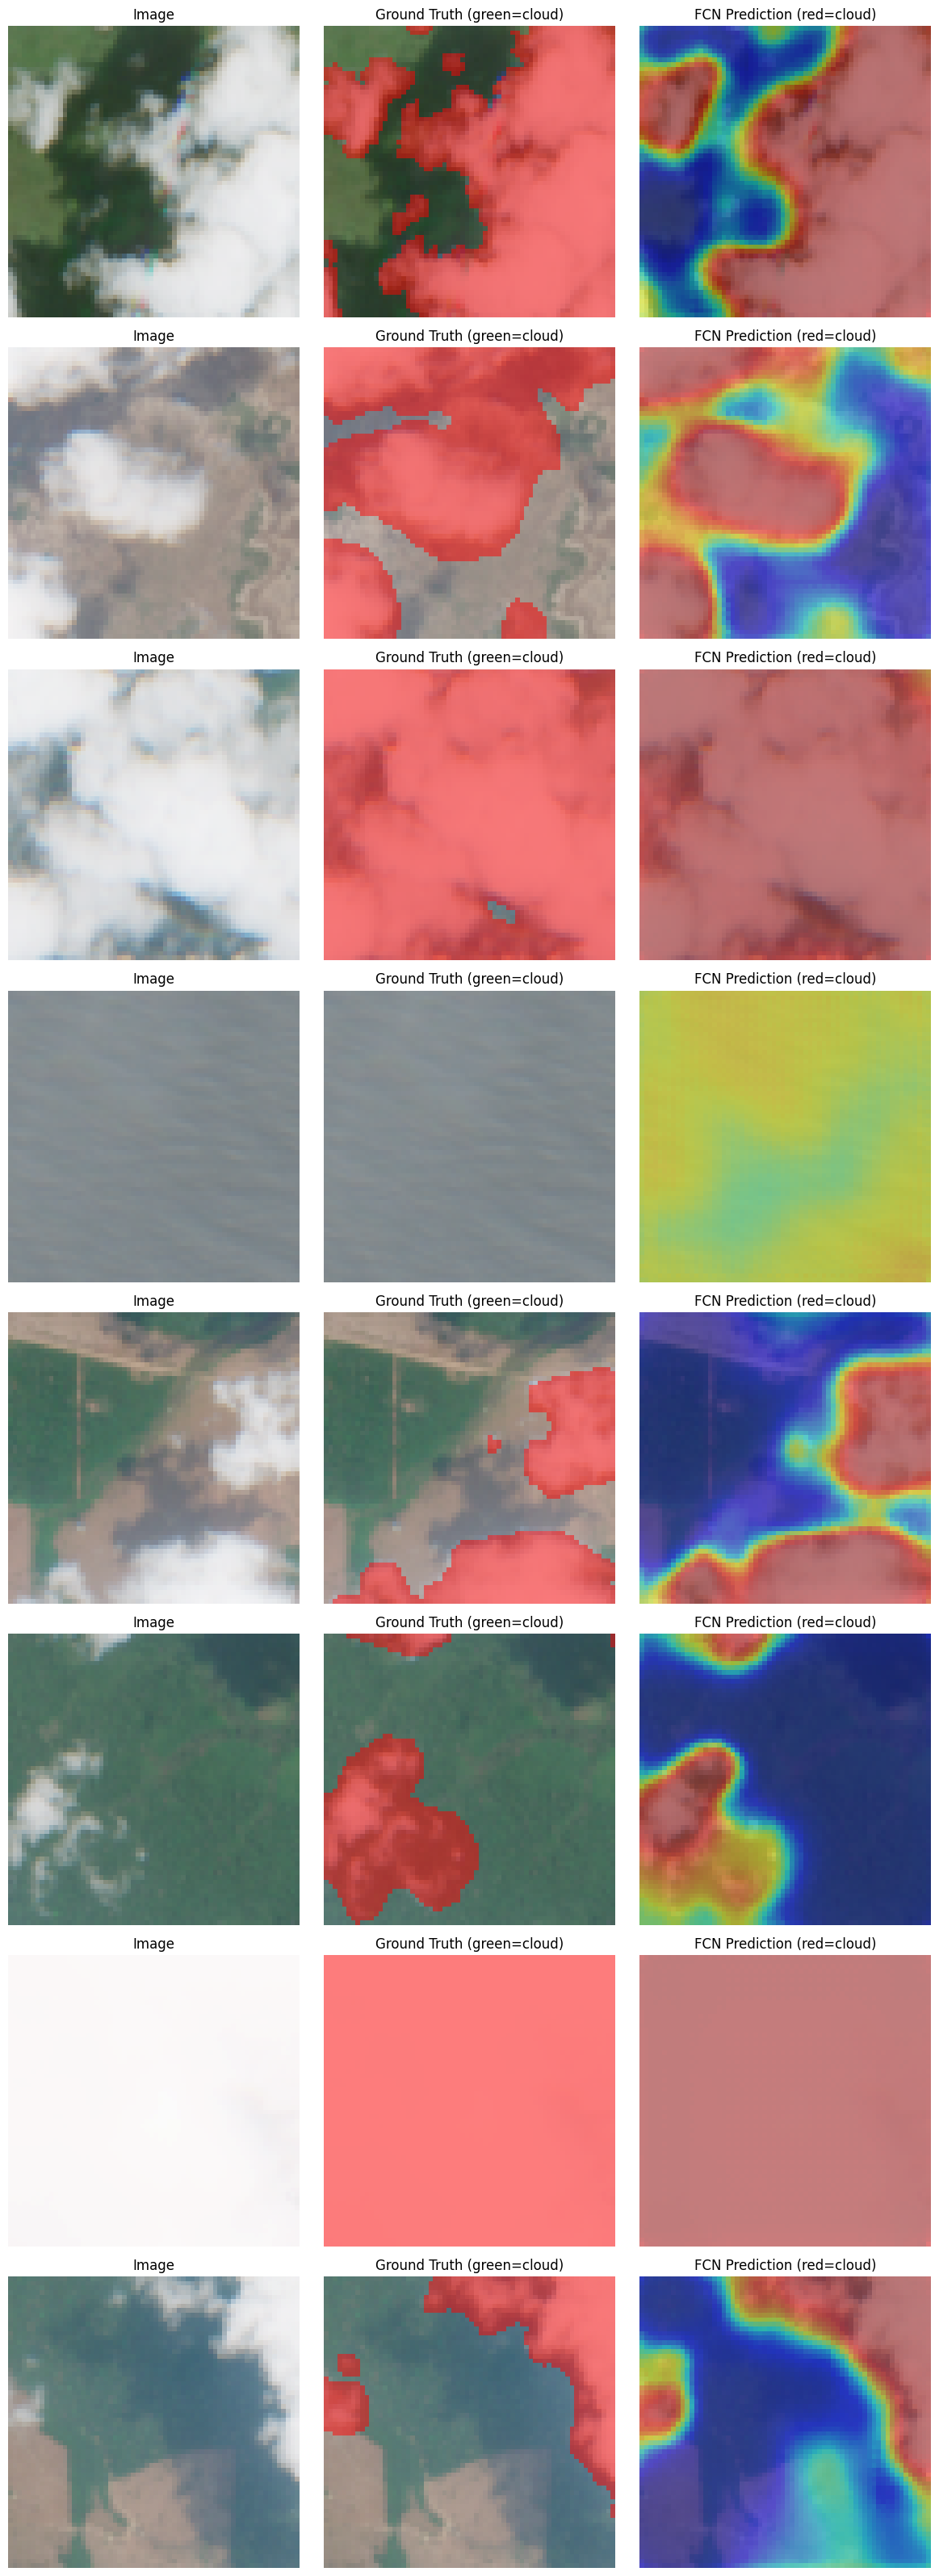

In [88]:
visualize_segmentation_predictions(fcn_model, val_dataset, device, num_samples=8)

**Observation:** The FCN produces reasonable segmentation masks, but boundaries are often **blurry** or **imprecise**. This happens because:
1. We lost fine spatial details during downsampling (pooling)
2. The decoder can't recover information that was discarded

**Solution:** Add skip connections to preserve spatial information!

## Part 5: UNet with Skip Connections

### Why Skip Connections?

**Problem with FCN:**
- Early encoder features (high-resolution) have fine spatial details
- Late encoder features (low-resolution) have semantic information
- Decoder only sees late features → blurry boundaries

**UNet Solution:**
- **Concatenate** encoder features directly to decoder at matching resolutions
- Decoder gets both: semantic info (from bottleneck) + spatial details (from encoder)
- Result: Sharp boundaries!

```
Encoder:              Decoder:
(32, 64, 64) --------→ concat → (64+32, 64, 64)
(64, 32, 32) ------→ concat → (128+64, 32, 32)
(128, 16, 16) ----→ concat → (256+128, 16, 16)
(128, 8, 8) ← Bottleneck
```

![UNet](https://towardsdatascience.com/wp-content/uploads/2022/11/1LH_JiIJngSllUZ0F8JYcwQ.png)

### UNet Encoder (with feature storage)

In [89]:
class UNetEncoder(nn.Module):
    """
    UNet Encoder: Same as FCN but returns intermediate features for skip connections
    """

    def __init__(self):
        super().__init__()
        # Level 1
        self.conv1 = ConvBlock(3, 32)
        self.pool1 = nn.MaxPool2d(2)

        # Level 2
        self.conv2 = ConvBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        # Level 3
        self.conv3 = ConvBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(128, 128)

    def forward(self, x) -> Tuple[Tensor, List[Tensor]]:
        # Store features for skip connections
        x1 = self.conv1(x)  # (32, 64, 64)
        x = self.pool1(x1)

        x2 = self.conv2(x)  # (64, 32, 32)
        x = self.pool2(x2)

        x3 = self.conv3(x)  # (128, 16, 16)
        x = self.pool3(x3)

        x = self.bottleneck(x)  # (128, 8, 8)

        # Return bottleneck and skip connection features
        return x, (x3, x2, x1)

### UNet Decoder (with skip connections)

**Exercise:** Complete the decoder with skip connections.

**Hints:**
- After upsampling, concatenate with encoder features: `torch.cat([x, skip_feat], dim=1)`
- Adjust `ConvBlock` input channels to account for concatenated features
- Example: If upsampled feature is 64 channels and skip is 64 channels → input is 128 channels

In [90]:
class UNetDecoder(nn.Module):
    """
    UNet Decoder: Upsampling with skip connections from encoder
    """

    def __init__(self):
        super().__init__()
        # Level 1: 8×8 → 16×16
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1 = ConvBlock(64 + 128, 64)  # +128 from skip connection

        # Level 2: 16×16 → 32×32
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv2 = ConvBlock(32 + 64, 32)  # +64 from skip connection

        # Level 3: 32×32 → 64×64
        self.upconv3 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv3 = ConvBlock(16 + 32, 16)  # +32 from skip connection

        # Final layer: 1×1 conv + Sigmoid for binary segmentation
        self.final_conv = nn.Conv2d(16, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: Tensor, skip_features: List[Tensor]) -> Tensor:
        """
        Args:
            x: bottleneck features (B, 128, 8, 8)
            skip_features: list of [x3, x2, x1] from encoder
        """
        # Unpack skip connections
        x3, x2, x1 = skip_features

        # Level 1
        x = self.upconv1(x)  # (64, 16, 16)
        x = torch.cat([x, x3], dim=1)  # Concatenate skip connection
        x = self.conv1(x)  # (64, 16, 16)

        # Level 2
        x = self.upconv2(x)  # (32, 32, 32)
        x = torch.cat([x, x2], dim=1)  # Concatenate skip connection
        x = self.conv2(x)  # (32, 32, 32)

        # Level 3
        x = self.upconv3(x)  # (16, 64, 64)
        x = torch.cat([x, x1], dim=1)  # Concatenate skip connection
        x = self.conv3(x)  # (16, 64, 64)

        # Final classification
        x = self.final_conv(x)  # (1, 64, 64) - logits
        x = self.sigmoid(x)  # (1, 64, 64) - probabilities

        return x

### Complete UNet Model

In [91]:
class UNet(nn.Module):
    """
    UNet for binary segmentation with skip connections
    Input: (B, 3, H, W)
    Output: (B, 1, H, W) - cloud probability per pixel
    """

    def __init__(self):
        super().__init__()
        self.encoder = UNetEncoder()
        self.decoder = UNetDecoder()

    def forward(self, x):
        # Encode (get bottleneck and skip features)
        bottleneck, skip_features = self.encoder(x)
        # Decode (use skip connections)
        output = self.decoder(bottleneck, skip_features)
        return output

In [92]:
# Instantiate UNet
unet_model = UNet().to(device)

In [93]:
# Verify architecture
dummy_output = unet_model(dummy_input)
print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {dummy_output.shape}")
print(f"✓ UNet produces same output shape as FCN")

Input shape: torch.Size([2, 3, 64, 64])
Output shape: torch.Size([2, 1, 64, 64])
✓ UNet produces same output shape as FCN


In [94]:
# Model summary
print("\nUNet Architecture:")
torchinfo.summary(unet_model, input_size=(1, 3, 64, 64), device=device)


UNet Architecture:


Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 64, 64]            --
├─UNetEncoder: 1-1                       [1, 128, 8, 8]            --
│    └─ConvBlock: 2-1                    [1, 32, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 32, 64, 64]           896
│    │    └─ReLU: 3-2                    [1, 32, 64, 64]           --
│    │    └─Conv2d: 3-3                  [1, 32, 64, 64]           9,248
│    │    └─ReLU: 3-4                    [1, 32, 64, 64]           --
│    └─MaxPool2d: 2-2                    [1, 32, 32, 32]           --
│    └─ConvBlock: 2-3                    [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-5                  [1, 64, 32, 32]           18,496
│    │    └─ReLU: 3-6                    [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-7                  [1, 64, 32, 32]           36,928
│    │    └─ReLU: 3-8                    [1, 64, 32, 32]           --
│  

### Training UNet

In [95]:
# Optimizer for UNet
unet_optimizer = optim.Adam(unet_model.parameters(), lr=LEARNING_RATE)

In [96]:
# Training loop
unet_train_losses = []
unet_val_losses = []

print("Training UNet...")
for epoch in tqdm.trange(EPOCHS):
    train_loss = train_epoch_segmentation(
        unet_model, train_loader, criterion, unet_optimizer, device
    )
    val_loss = val_epoch_segmentation(unet_model, val_loader, criterion, device)

    unet_train_losses.append(train_loss)
    unet_val_losses.append(val_loss)

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

print("✓ UNet training complete!")

Training UNet...


100%|██████████| 5/5 [00:53<00:00, 10.76s/it]

Epoch [5/5] - Train Loss: 0.2793, Val Loss: 0.2696
✓ UNet training complete!


In [97]:
import torch.jit

# Put the model in eval mode
unet_model = unet_model.cpu().eval()

# Script the model
scripted_model = torch.jit.script(unet_model)

# Save
scripted_model.save("unet_scripted_model.pt")

print(scripted_model)

# Scripted model reloading (demo)
scripted_model = torch.jit.load("unet_scripted_model.pt", map_location=device)

RecursiveScriptModule(
  original_name=UNet
  (encoder): RecursiveScriptModule(
    original_name=UNetEncoder
    (conv1): RecursiveScriptModule(
      original_name=ConvBlock
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (relu1): RecursiveScriptModule(original_name=ReLU)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (relu2): RecursiveScriptModule(original_name=ReLU)
    )
    (pool1): RecursiveScriptModule(original_name=MaxPool2d)
    (conv2): RecursiveScriptModule(
      original_name=ConvBlock
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (relu1): RecursiveScriptModule(original_name=ReLU)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (relu2): RecursiveScriptModule(original_name=ReLU)
    )
    (pool2): RecursiveScriptModule(original_name=MaxPool2d)
    (conv3): RecursiveScriptModule(
      original_name=ConvBlock
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (relu1): RecursiveScriptModule(

### Comparing Training Curves: FCN vs UNet

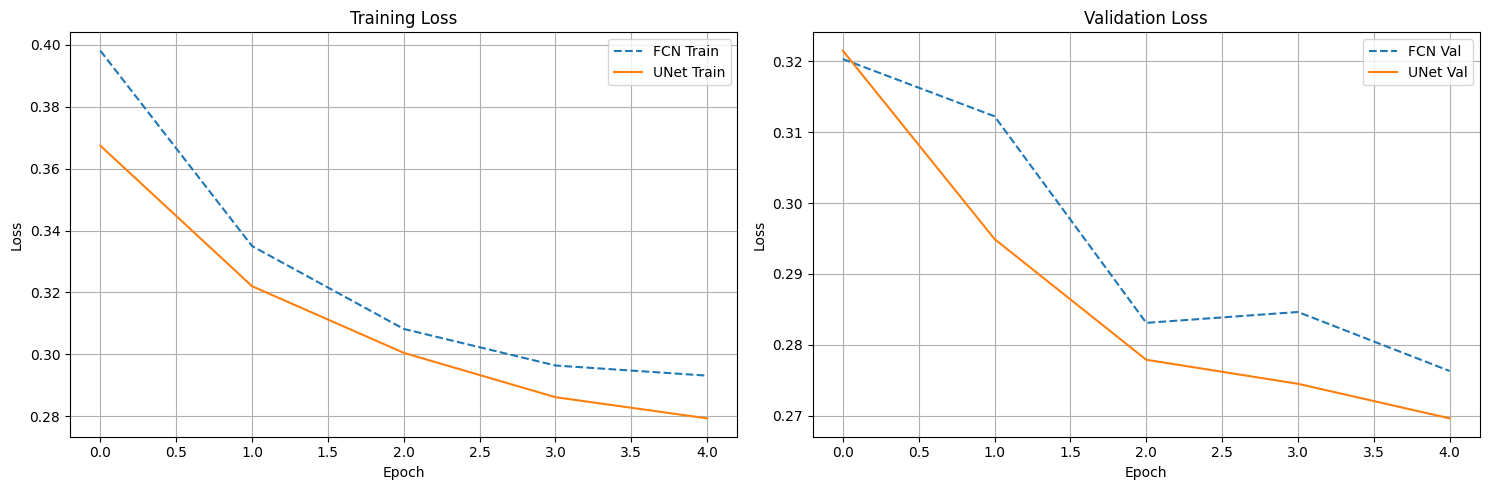

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training loss
axes[0].plot(fcn_train_losses, label="FCN Train", linestyle="--")
axes[0].plot(unet_train_losses, label="UNet Train", linestyle="-")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss")
axes[0].legend()
axes[0].grid(True)

# Validation loss
axes[1].plot(fcn_val_losses, label="FCN Val", linestyle="--")
axes[1].plot(unet_val_losses, label="UNet Val", linestyle="-")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Validation Loss")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Side-by-Side Comparison: FCN vs UNet

In [101]:
def compare_models(fcn_model, unet_model, dataset, device, num_samples=6):
    """Compare FCN and UNet predictions side-by-side"""
    fcn_model.eval()
    # Ensure unet_model is on the correct device for evaluation
    unet_model.to(device).eval()

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

    with torch.no_grad():
        for i in range(num_samples):
            img_tensor, mask_gt = dataset[i]
            img_tensor_batch = img_tensor.unsqueeze(0).to(device)

            # FCN prediction
            fcn_output = fcn_model(img_tensor_batch)  # (1, 1, H, W)
            fcn_pred = fcn_output.squeeze(0).squeeze(0).cpu()  # (H, W) float

            # UNet prediction
            unet_output = unet_model(img_tensor_batch)  # (1, 1, H, W)
            unet_pred = unet_output.squeeze(0).squeeze(0).cpu()  # (H, W) float

            # Visualize
            img_np = inverse_transform(img_tensor, mean, std)

            # Create overlays
            gt_overlay = overlay_img_msk(img_np, mask_gt.numpy(), color="red")
            fcn_overlay = overlay_img_prd(img_np, fcn_pred.numpy(), cmap="jet")
            unet_overlay = overlay_img_prd(img_np, unet_pred.numpy(), cmap="viridis")

            axes[i, 0].imshow(img_np)
            axes[i, 0].set_title("Image")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(gt_overlay)
            axes[i, 1].set_title("Ground Truth (red)")
            axes[i, 1].axis("off")

            axes[i, 2].imshow(fcn_overlay)
            axes[i, 2].set_title("FCN not thresholded (cmap jet)")
            axes[i, 2].axis("off")

            axes[i, 3].imshow(unet_overlay)
            axes[i, 3].set_title("UNet not thresholded (cmap viridis)")
            axes[i, 3].axis("off")

    plt.tight_layout()
    plt.show()

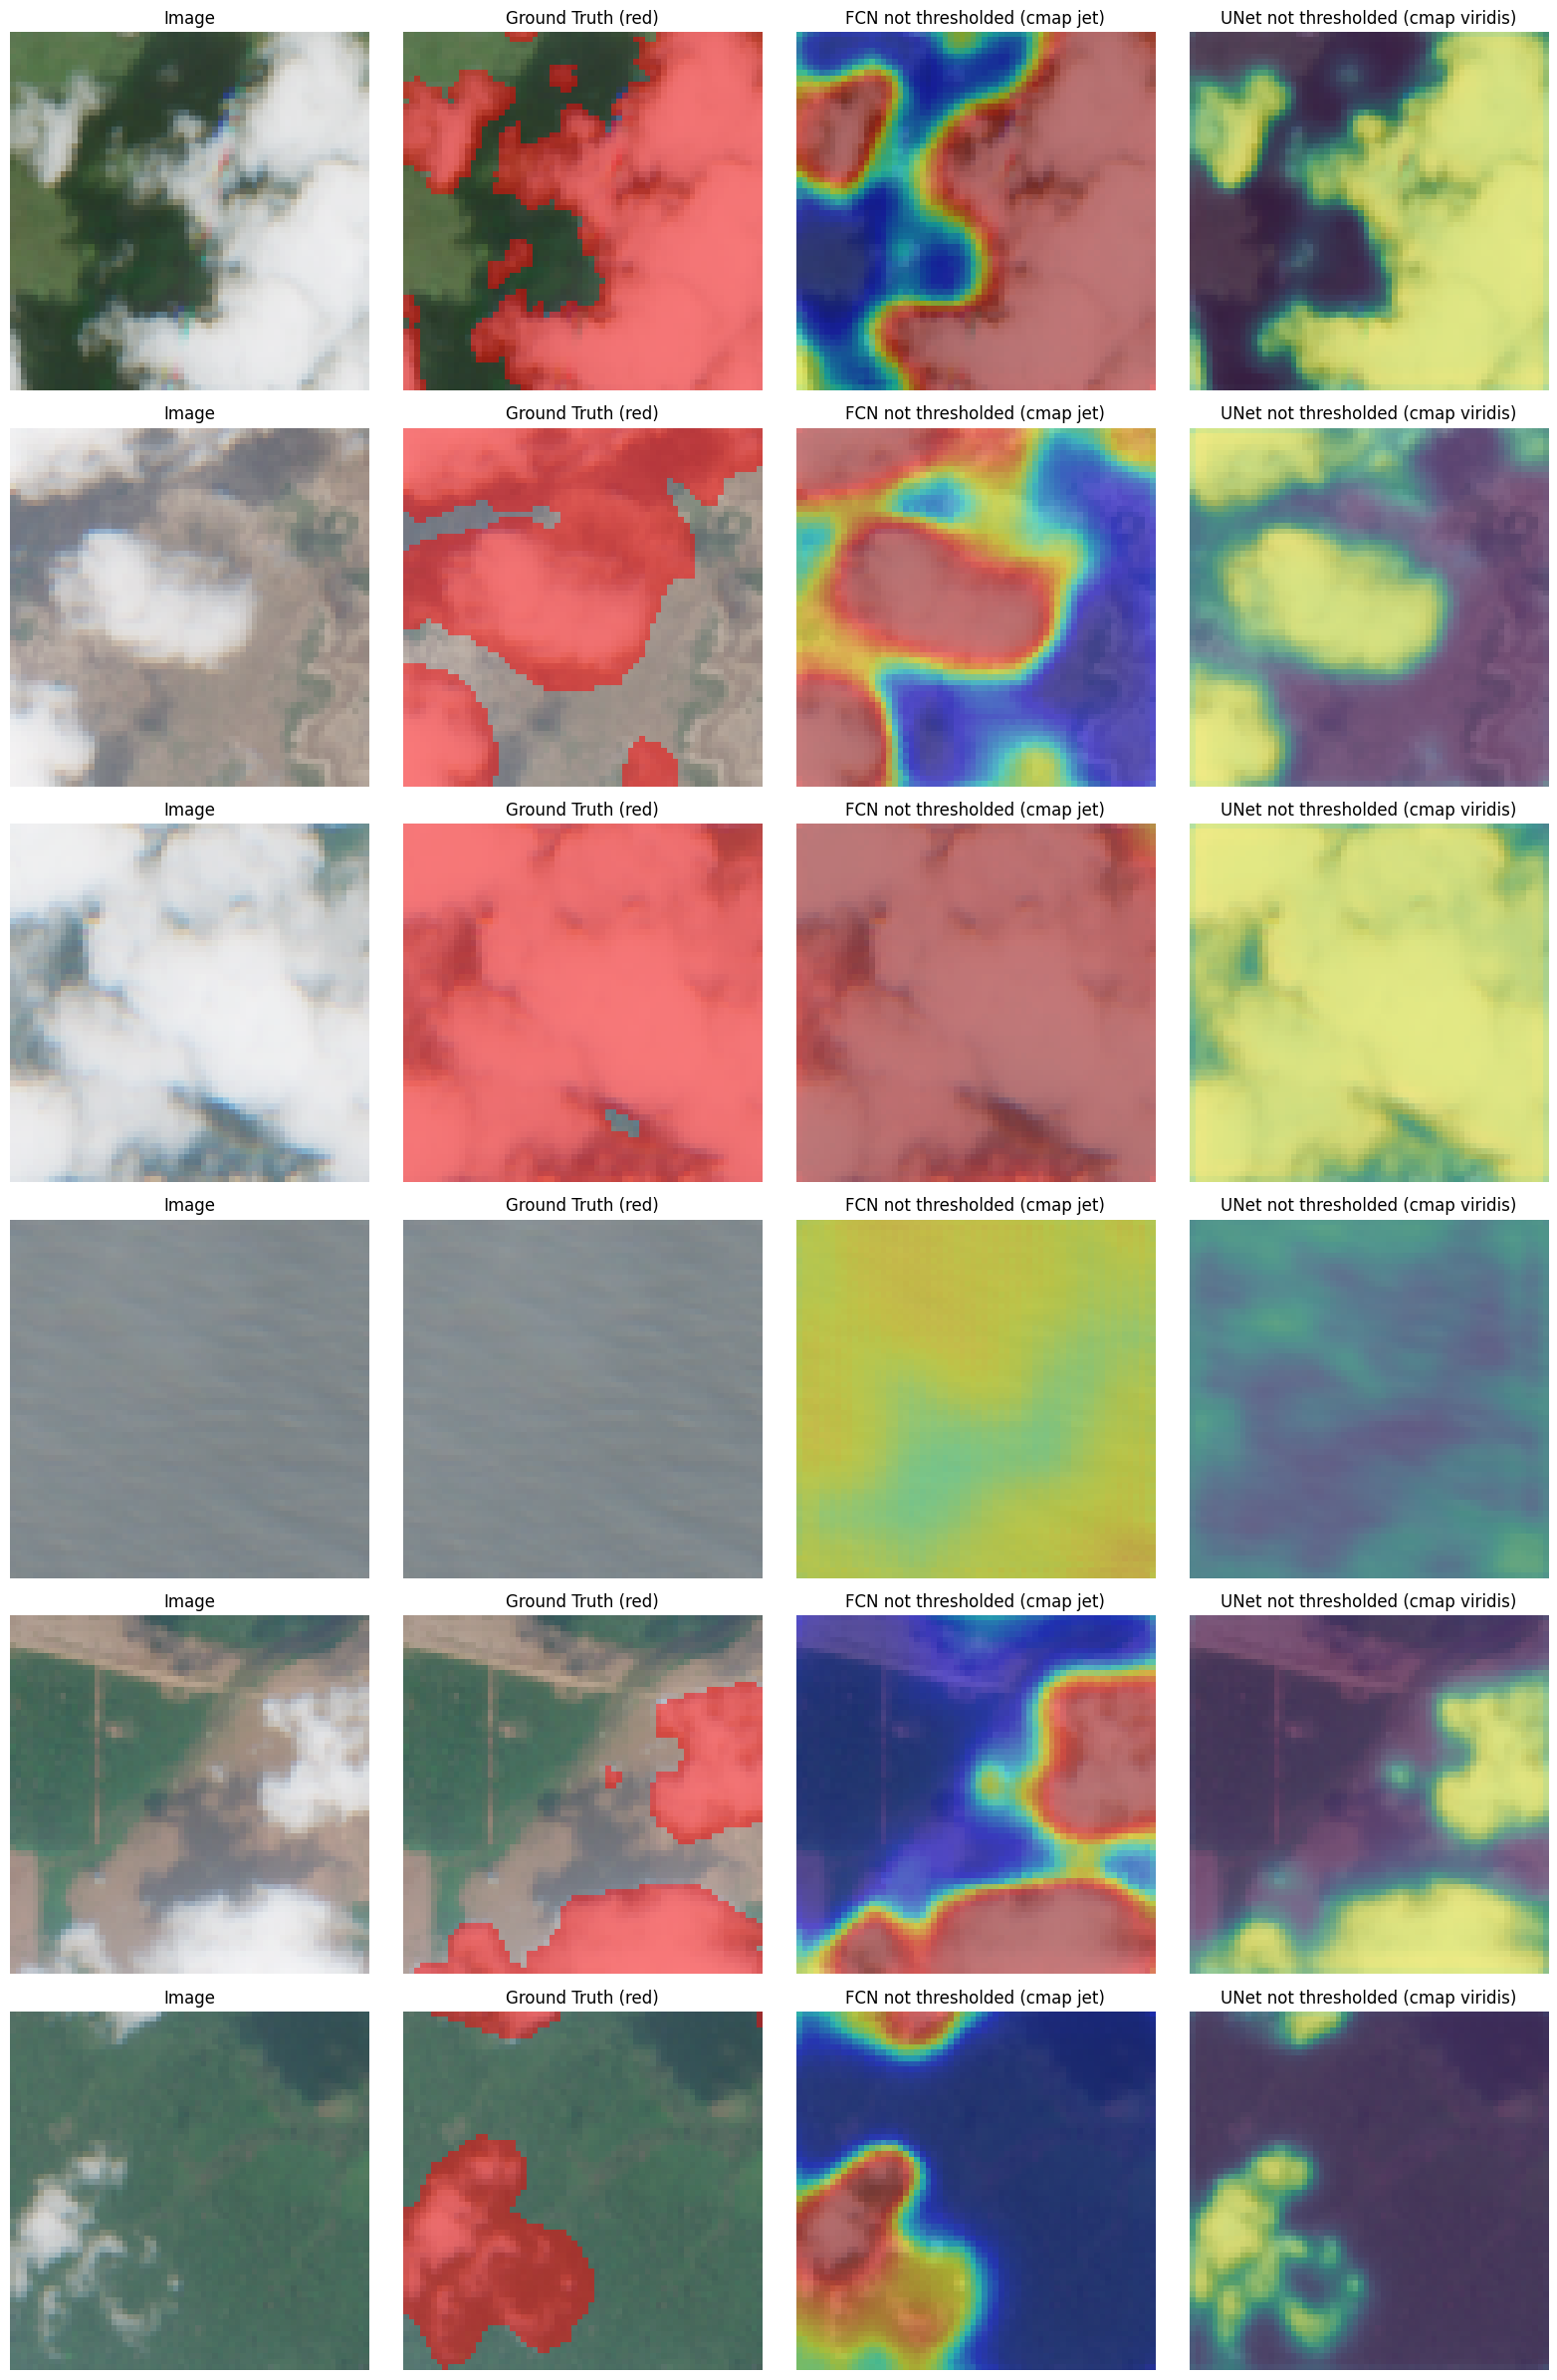

In [102]:
compare_models(fcn_model, unet_model, val_dataset, device, num_samples=6)

**Key Observation:** UNet predictions have **sharper boundaries** compared to FCN! The skip connections allow the decoder to recover fine spatial details that were lost during downsampling.

## Part 6: Quantitative Evaluation

### ROC CURVE

First, you can transpose the code that you had for the ROC curve in the classication case to the segmentation case to determine the thresholds.

It's the same, except you now get 1 sample per pixel instead of 1 sample per image

In [117]:
# Do it HERE

### Segmentation Metrics

Unlike classification (accuracy, precision, recall), segmentation uses:

**1. Intersection over Union (IoU) / Jaccard Index:**
```
IoU = (TP) / (TP + FP + FN)
    = Area of Overlap / Area of Union
```
- Range: [0, 1], higher is better
- Penalizes both false positives and false negatives

**2. Dice Coefficient / F1 Score:**
```
Dice = 2 * TP / (2 * TP + FP + FN)
     = 2 * IoU / (1 + IoU)
```
- Range: [0, 1], higher is better
- More weight on true positives than IoU

**3. Pixel Accuracy:**
```
Pixel Acc = (TP + TN) / (TP + TN + FP + FN)
```
- Can be misleading for imbalanced classes

In [104]:
def compute_iou(pred, target, threshold=0.5):
    """
    Compute IoU for binary segmentation
    Args:
        pred: (B, H, W) predicted probabilities (floats in [0, 1])
        target: (B, H, W) ground truth binary masks
        threshold: threshold to binarize predictions
    Returns:
        iou: IoU score for cloud class (positive class)
    """
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()

    # Binarize predictions
    pred_binary = (pred >= threshold).astype(np.uint8)

    # Compute IoU for cloud class (class 1)
    intersection = np.logical_and(pred_binary, target).sum()
    union = np.logical_or(pred_binary, target).sum()

    if union == 0:
        return float("nan")
    else:
        return intersection / union


def compute_dice(pred, target, threshold=0.5):
    """
    Compute Dice coefficient for binary segmentation
    """
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()

    # Binarize predictions
    pred_binary = (pred >= threshold).astype(np.uint8)

    # Compute Dice for cloud class
    intersection = np.logical_and(pred_binary, target).sum()
    pred_sum = pred_binary.sum()
    target_sum = target.sum()

    if pred_sum + target_sum == 0:
        return float("nan")
    else:
        return 2 * intersection / (pred_sum + target_sum)


def compute_pixel_accuracy(pred, target, threshold=0.5):
    """
    Compute overall pixel accuracy
    """
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()

    # Binarize predictions
    pred_binary = (pred >= threshold).astype(np.uint8)

    correct = (pred_binary == target).sum()
    total = pred.size
    return correct / total

### Evaluating Both Models on Test Set

In [105]:
def evaluate_model(model, dataloader, device, threshold=0.5):
    """
    Evaluate model on entire dataset for binary segmentation
    Returns:
        mean_iou: IoU score for cloud class
        mean_dice: Dice score for cloud class
        pixel_acc: overall pixel accuracy
    """
    model.eval()
    all_ious = []
    all_dices = []
    all_pixel_accs = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            # Predict
            outputs = model(images)  # (B, 1, H, W) probabilities
            preds = outputs.squeeze(1)  # (B, H, W) probabilities

            # Compute metrics
            iou = compute_iou(preds, masks, threshold)
            dice = compute_dice(preds, masks, threshold)
            pixel_acc = compute_pixel_accuracy(preds, masks, threshold)

            all_ious.append(iou)
            all_dices.append(dice)
            all_pixel_accs.append(pixel_acc)

    # Average across batches (ignore nan values)
    mean_iou = np.nanmean(all_ious)
    mean_dice = np.nanmean(all_dices)
    mean_pixel_acc = np.mean(all_pixel_accs)

    return mean_iou, mean_dice, mean_pixel_acc

In [106]:
# Evaluate FCN
print("Evaluating FCN on test set...")
fcn_iou, fcn_dice, fcn_pixel_acc = evaluate_model(
    fcn_model, test_loader, device, threshold=0.5
)

print("\nFCN Results (threshold=0.5):")
print(f"  IoU (Cloud class): {fcn_iou:.4f}")
print(f"  Dice (Cloud class): {fcn_dice:.4f}")
print(f"  Pixel Accuracy: {fcn_pixel_acc:.4f}")

Evaluating FCN on test set...

FCN Results (threshold=0.5):
  IoU (Cloud class): 0.7491
  Dice (Cloud class): 0.8534
  Pixel Accuracy: 0.8827


In [107]:
# Evaluate UNet
print("Evaluating UNet on test set...")
unet_iou, unet_dice, unet_pixel_acc = evaluate_model(
    unet_model, test_loader, device, threshold=0.5
)

print("\nUNet Results (threshold=0.5):")
print(f"  IoU (Cloud class): {unet_iou:.4f}")
print(f"  Dice (Cloud class): {unet_dice:.4f}")
print(f"  Pixel Accuracy: {unet_pixel_acc:.4f}")

Evaluating UNet on test set...

UNet Results (threshold=0.5):
  IoU (Cloud class): 0.7417
  Dice (Cloud class): 0.8478
  Pixel Accuracy: 0.8886


### Metrics Comparison Table

In [108]:
import pandas as pd

# Create comparison table
comparison_df = pd.DataFrame(
    {
        "Model": ["FCN", "UNet"],
        "IoU (Cloud)": [fcn_iou, unet_iou],
        "Dice (Cloud)": [fcn_dice, unet_dice],
        "Pixel Accuracy": [fcn_pixel_acc, unet_pixel_acc],
    }
)

print("\n" + "=" * 60)
print("QUANTITATIVE COMPARISON")
print("=" * 60)
print(comparison_df.to_string(index=False))
print("=" * 60)

improvement_iou = ((unet_iou - fcn_iou) / fcn_iou) * 100
improvement_dice = ((unet_dice - fcn_dice) / fcn_dice) * 100

print(f"\nUNet improvements over FCN:")
print(f"  IoU: +{improvement_iou:.1f}%")
print(f"  Dice: +{improvement_dice:.1f}%")


QUANTITATIVE COMPARISON
Model  IoU (Cloud)  Dice (Cloud)  Pixel Accuracy
  FCN     0.749101      0.853419        0.882716
 UNet     0.741688      0.847845        0.888557

UNet improvements over FCN:
  IoU: +-1.0%
  Dice: +-0.7%


### Visualization: Best and Worst Cases

In [109]:
def find_best_worst_predictions(model, dataset, device, num_samples=3, threshold=0.5):
    """
    Find best and worst predictions based on IoU
    Returns indices of best and worst samples
    """
    model.eval()
    sample_ious = []

    with torch.no_grad():
        for i in range(len(dataset)):
            img_tensor, mask_gt = dataset[i]
            img_tensor_batch = img_tensor.unsqueeze(0).to(device)

            output = model(img_tensor_batch)  # (1, 1, H, W)
            pred_mask = output.squeeze(0).squeeze(0)  # (H, W) probabilities

            iou = compute_iou(pred_mask.unsqueeze(0), mask_gt.unsqueeze(0), threshold)
            sample_ious.append((i, iou))

    # Sort by IoU
    sample_ious.sort(key=lambda x: x[1])

    worst_indices = [idx for idx, _ in sample_ious[:num_samples]]
    best_indices = [idx for idx, _ in sample_ious[-num_samples:]]

    return best_indices, worst_indices

In [110]:
# Find best/worst for UNet
best_idx, worst_idx = find_best_worst_predictions(
    unet_model, test_dataset, device, num_samples=3
)

Best UNet Predictions (Highest IoU):


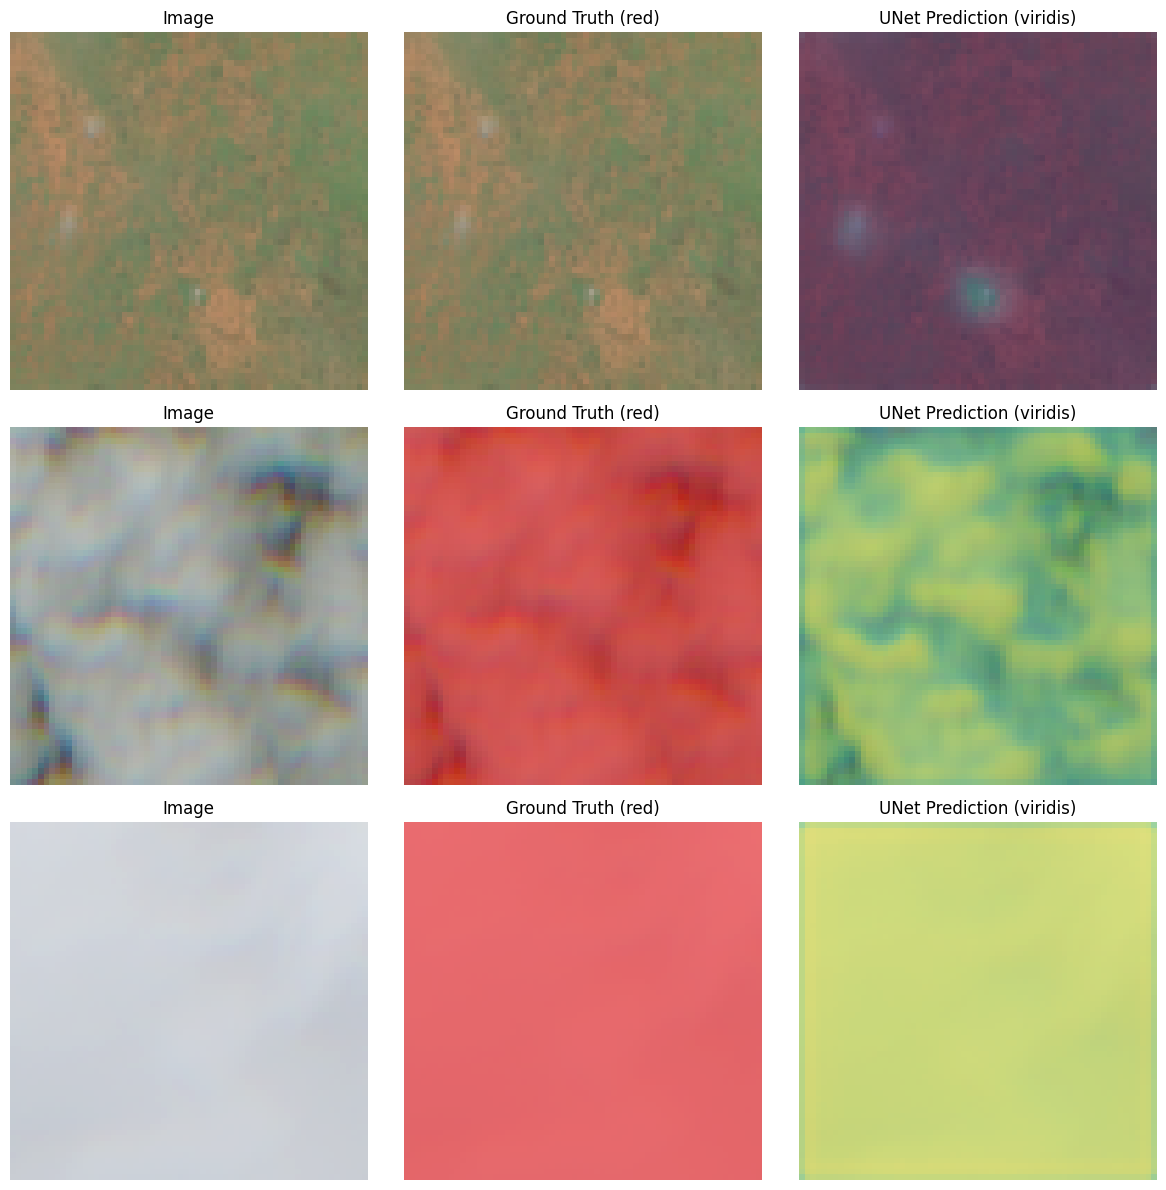

In [111]:
# Visualize best cases
print("Best UNet Predictions (Highest IoU):")
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
unet_model.eval()

with torch.no_grad():
    for i, idx in enumerate(best_idx):
        img_tensor, mask_gt = test_dataset[idx]
        img_tensor_batch = img_tensor.unsqueeze(0).to(device)

        output = unet_model(img_tensor_batch)  # (1, 1, H, W)
        pred_mask = output.squeeze(0).squeeze(0).cpu()  # (H, W) probabilities

        img_np = inverse_transform(img_tensor, mean, std)

        # Create overlays
        gt_overlay = overlay_img_msk(img_np, mask_gt.numpy(), color="red")
        pred_overlay = overlay_img_prd(img_np, pred_mask.numpy(), cmap="viridis")

        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title("Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(gt_overlay)
        axes[i, 1].set_title("Ground Truth (red)")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred_overlay)
        axes[i, 2].set_title("UNet Prediction (viridis)")
        axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

Worst UNet Predictions (Lowest IoU):


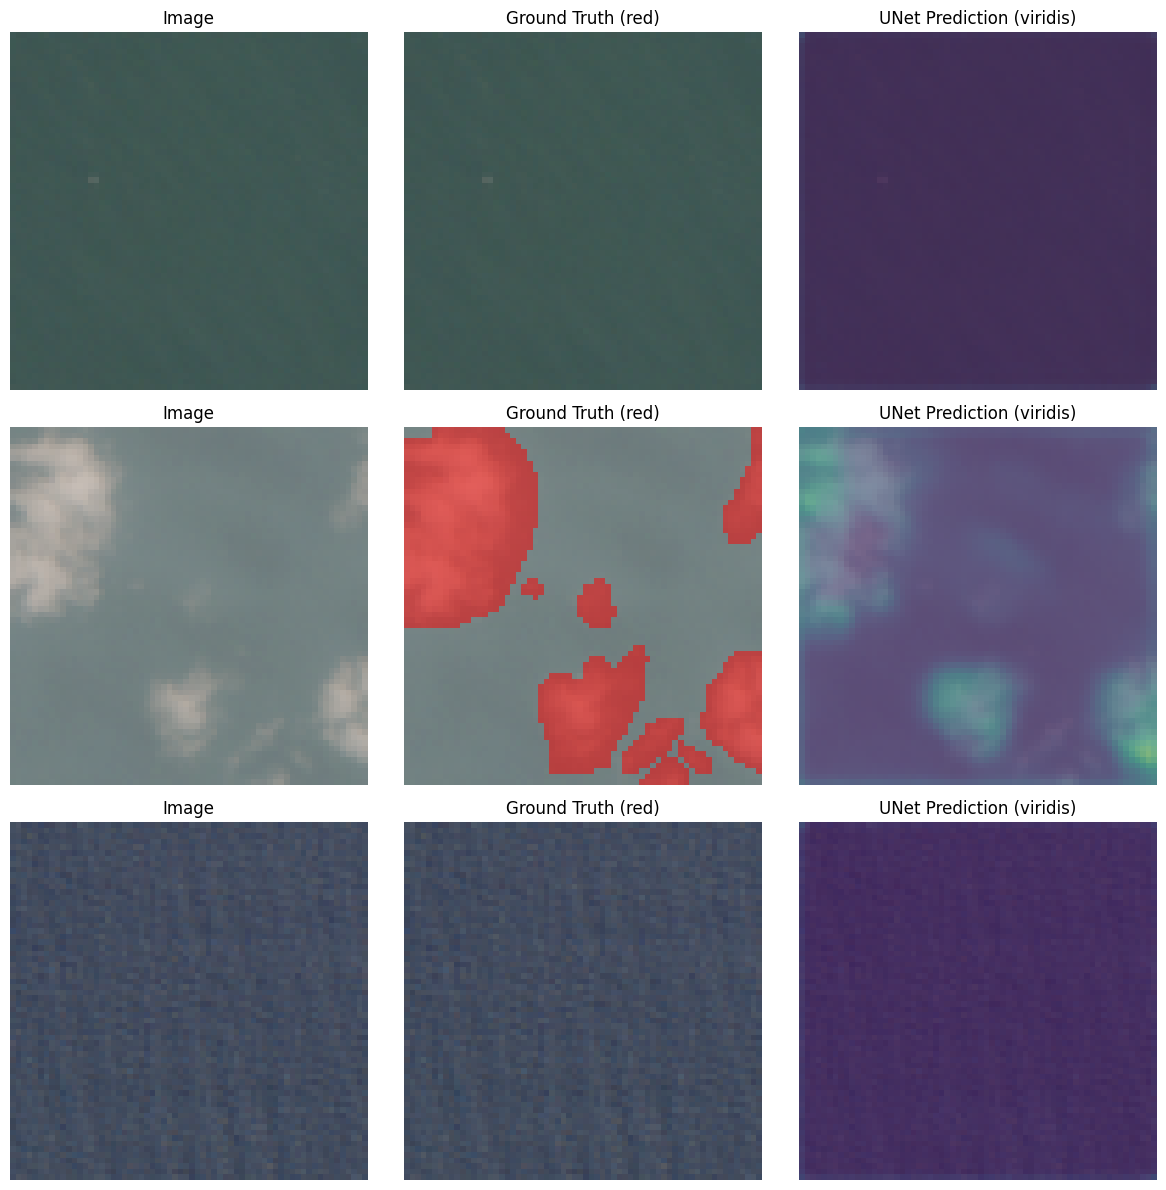

In [112]:
# Visualize worst cases
print("Worst UNet Predictions (Lowest IoU):")
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

with torch.no_grad():
    for i, idx in enumerate(worst_idx):
        img_tensor, mask_gt = test_dataset[idx]
        img_tensor_batch = img_tensor.unsqueeze(0).to(device)

        output = unet_model(img_tensor_batch)  # (1, 1, H, W)
        pred_mask = output.squeeze(0).squeeze(0).cpu()  # (H, W) probabilities

        img_np = inverse_transform(img_tensor, mean, std)

        # Create overlays
        gt_overlay = overlay_img_msk(img_np, mask_gt.numpy(), color="red")
        pred_overlay = overlay_img_prd(img_np, pred_mask.numpy(), cmap="viridis")

        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title("Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(gt_overlay)
        axes[i, 1].set_title("Ground Truth (red)")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred_overlay)
        axes[i, 2].set_title("UNet Prediction (viridis)")
        axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

## Congratulations !

Now save your precious Unet and go to the next notebook to view your results !

In [122]:
import torch.jit

# Put the model in eval mode
unet_model = unet_model.cpu().eval()

# Script the model
scripted_model = torch.jit.script(unet_model)

# Save
scripted_model.save("scripted_unet_model.pt")

print(scripted_model)

# Scripted model reloading (demo)
scripted_model = torch.jit.load("scripted_unet_model.pt", map_location=device)

# See below for how to reload the model


RecursiveScriptModule(
  original_name=UNet
  (encoder): RecursiveScriptModule(
    original_name=UNetEncoder
    (conv1): RecursiveScriptModule(
      original_name=ConvBlock
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (relu1): RecursiveScriptModule(original_name=ReLU)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (relu2): RecursiveScriptModule(original_name=ReLU)
    )
    (pool1): RecursiveScriptModule(original_name=MaxPool2d)
    (conv2): RecursiveScriptModule(
      original_name=ConvBlock
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (relu1): RecursiveScriptModule(original_name=ReLU)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (relu2): RecursiveScriptModule(original_name=ReLU)
    )
    (pool2): RecursiveScriptModule(original_name=MaxPool2d)
    (conv3): RecursiveScriptModule(
      original_name=ConvBlock
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (relu1): RecursiveScriptModule(

In [123]:
from google.colab import files

files.download('scripted_unet_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Part 7: Advanced Topics (Optional Exercises)

### Exercise 1: Data Augmentation for Segmentation

**Challenge:** Implement data augmentation that transforms **both image and mask together**.

**Important:** Geometric transforms (flip, rotation, crop) must be applied identically to image and mask!

**Hints:**
- Use `torchvision.transforms.functional` for deterministic transforms
- Apply same random parameters to both image and mask
- Example: If you flip image horizontally, flip mask horizontally too

### Exercise 2: Alternative Loss Functions

**Challenge:** Implement and compare different loss functions for segmentation.

**Try:**
1. **Dice Loss:** Directly optimize Dice coefficient
   ```python
   Dice Loss = 1 - Dice Coefficient
   ```

2. **Combined Loss:** Mix CrossEntropy and Dice
   ```python
   Loss = α * CE + (1 - α) * Dice
   ```

3. **Focal Loss:** Handle class imbalance better

**Hint:** Dice loss is differentiable - you can use it as a loss function!

In [114]:
class DiceLoss(nn.Module):
    """
    Dice Loss for binary segmentation
    Works with model output (probabilities after Sigmoid)
    """

    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        """
        Args:
            pred: (B, 1, H, W) probabilities after sigmoid [0, 1]
            target: (B, 1, H, W) binary ground truth masks
        """
        # Flatten spatial dimensions
        pred_flat = pred.view(-1)  # (B*H*W,)
        target_flat = target.view(-1)  # (B*H*W,)

        # Compute Dice coefficient
        intersection = (pred_flat * target_flat).sum()
        union = pred_flat.sum() + target_flat.sum()

        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)

        # Dice loss = 1 - Dice
        return 1 - dice

**Try it:**
```python
dice_loss = DiceLoss()
optimizer = optim.SGD(unet_model.parameters(), lr=LEARNING_RATE)

# Train with Dice loss instead of CrossEntropy
for epoch in range(EPOCHS):
    train_loss = train_epoch_segmentation(unet_model, train_loader, dice_loss, optimizer, device)
    ...
```

### Exercise 3: Modify UNet Architecture

**Challenge:** Experiment with architectural changes:

1. **Deeper UNet:** Add more encoder-decoder levels (64×64 → 32×32 → 16×16 → 8×8 → **4×4**)
2. **Wider UNet:** Increase channel counts (32 → 64 → 128 → **256**)
3. **Different skip connections:**
   - Try **addition** instead of concatenation: `x = x + skip_feat`
   - Try **attention gates**: Weight skip connections by learned attention

**Question:** How does depth vs width affect:
- Model parameters?
- Training time?
- Segmentation quality?

### Exercise 4: Transfer Learning from Classification

**Challenge:** Can we reuse the encoder from Session 1's classification model?

**Idea:**
1. Train a classifier on large classification dataset (12,800 samples)
2. Extract the encoder weights (conv layers before flatten)
3. Initialize UNet encoder with these weights
4. Fine-tune on small segmentation dataset (256 samples)

**Hypothesis:** Pre-trained encoder might learn better features with limited segmentation data!

**Hint:** You'll need to match architecture dimensions between classification CNN and UNet encoder.

## Summary & Key Takeaways

### What We Learned

**1. Classification vs Segmentation:**
- Classification: 1 label per image → (B, 1) output
- Binary Segmentation: 1 probability per pixel → (B, 1, H, W) output (after Sigmoid)
- Multi-class Segmentation: C probabilities per pixel → (B, C, H, W) output

**2. Encoder-Decoder Architecture:**
- Encoder: Downsample to extract semantic features (like classification)
- Decoder: Upsample to recover spatial resolution (unique to segmentation)
- Key operation: `ConvTranspose2d` for learnable upsampling
- Output: Per-pixel probabilities via 1×1 Conv + Sigmoid (binary) or Softmax (multi-class)

**3. Importance of Skip Connections (UNet):**
- FCN: Only uses bottleneck features → blurry boundaries
- UNet: Concatenates encoder features → sharp boundaries
- Skip connections preserve spatial details lost during pooling
- Result: Better localization and finer segmentation quality

**4. Segmentation Metrics:**
- **IoU (Intersection over Union):** Area of overlap / Area of union
- **Dice coefficient:** 2×IoU / (1+IoU), more weight on TP
- Pixel accuracy can be misleading for imbalanced classes
- Threshold selection (0.5) affects all metrics - can be tuned like ROC in classification

**5. When to Use Each Architecture:**

| Architecture | Use Case | Trade-offs |
|--------------|----------|------------|
| **FCN** | Fast prototyping, coarse segmentation | Simpler, faster, but blurry |
| **UNet** | Precise boundaries needed | More parameters, sharper results |
| **UNet++** | Medical imaging, critical applications | Best quality, most complex |

**6. Key Differences from Classification Training:**
- Loss: `BCELoss` for binary (Sigmoid in model) or `BCEWithLogitsLoss` (Sigmoid in loss)
- Output: (B, 1, H, W) probabilities for binary, (B, C, H, W) for multi-class
- More memory intensive (predict every pixel!)
- Smaller datasets OK (more labels per sample - 64×64 labels vs 1)
- Data augmentation must transform image + mask together (geometric transforms)
- Threshold selection important for converting probabilities to binary predictions

### Going Further

**Advanced Architectures:**
- **DeepLabV3+:** Atrous convolutions for multi-scale context
- **Mask R-CNN:** Instance segmentation (distinguish individual objects)
- **SegFormer:** Transformer-based segmentation
- **SAM (Segment Anything):** Zero-shot segmentation with prompts

**Applications:**
- **Medical imaging:** Tumor segmentation, organ delineation
- **Autonomous driving:** Road, pedestrian, vehicle segmentation
- **Satellite imagery:** Land cover mapping, change detection
- **Agriculture:** Crop health monitoring, weed detection

**Resources:**
- [UNet paper (2015)](https://arxiv.org/abs/1505.04597) - Original medical imaging paper
- [Segmentation Models PyTorch](https://github.com/qubvel/segmentation_models.pytorch) - Pre-trained models
- [Albumentations](https://albumentations.ai/) - Fast augmentation library for segmentation
- [Papers With Code - Segmentation](https://paperswithcode.com/task/semantic-segmentation) - SOTA models

### Congratulations! 🎉

You've successfully:
- ✓ Understood the transition from classification to dense prediction
- ✓ Implemented encoder-decoder architectures (FCN)
- ✓ Built UNet with skip connections
- ✓ Evaluated models with IoU and Dice metrics
- ✓ Compared architectures quantitatively and qualitatively

**Next steps:** Try the optional exercises above or apply these techniques to your own segmentation problems!